## **PyTorch Workflow**


Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

### **1. Data (Preparing & loading)**

In [31]:
# import torch
import torch

# Create known parameters
weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [32]:
len(X), len(y)

(50, 50)

**Splitting data into training and testing sets:**

In [33]:
train_split = int(len(X)*0.80)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [34]:
import matplotlib.pyplot as plt

def plot_predictions(train_data, train_label, 
                     test_data, test_labels,
                     predictions = None):
    # Figure size
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_label, c = 'b', s = 15, label = 'Training Data')

    # Plot testing data in red 
    plt.scatter(test_data, test_labels, c = 'r', s = 15, label = 'Testing Data')

    # If there is any predictions 
    if predictions is not None:
        # plot predictions data if they exist 
        plt.scatter(test_data, predictions, c = 'g', s = 15, label = 'Predictions')

    plt.legend(prop = {'size': 14})

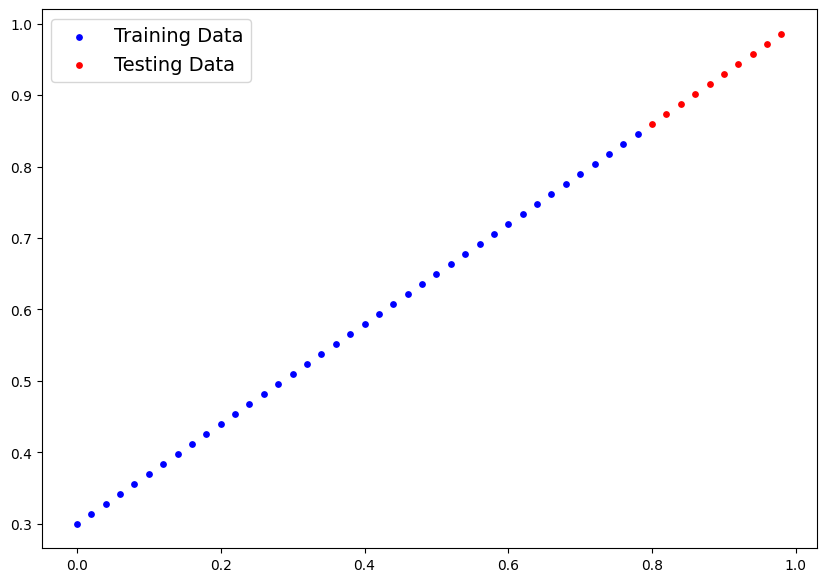

In [35]:
plot_predictions(X_train, y_train, X_test, y_test, None)

### **2. Build Model**

In [36]:
from torch import nn

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(
            1,
            requires_grad = True,
            dtype = torch.float32
        ))
        self.bias = nn.Parameter(torch.randn(
            1, 
            requires_grad = True,
            dtype = torch.float32
        ))
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.weights * x + self.bias

**Checking the contents of our PyTorch Model:**

In [37]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegression()

# Check out the parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [38]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

**Making predictions using `torch.inference_mode()`**

In [39]:
# Without inference mode (without training too)
y_preds = model_0(X_test)
y_preds[:5]

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251]], grad_fn=<SliceBackward0>)

In [40]:
# using inference mode
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds[:5], y_test[:5] 


(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160]]))

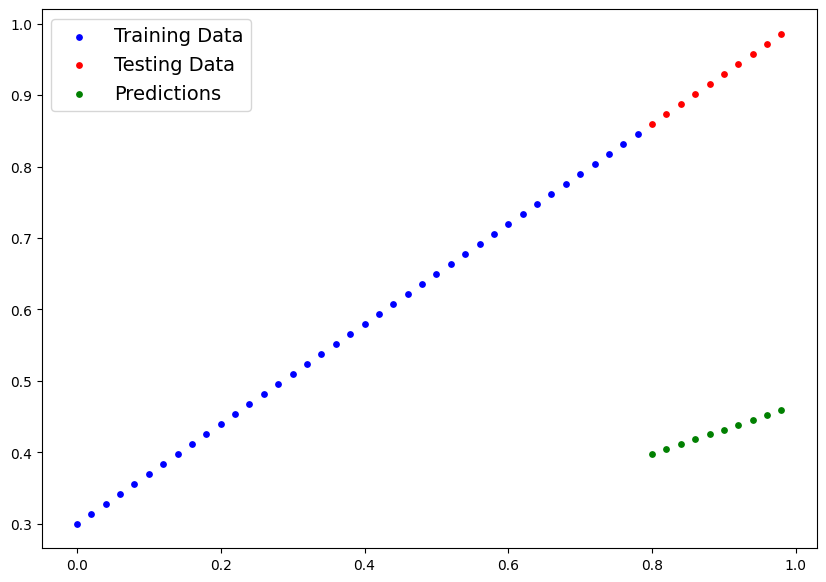

In [41]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

### ***Very bad Model***

### **3. Train Model**

In [42]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [43]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

> Note : **Before creating a training loop implement the `loss function` and `Optimizer`:**

In [44]:
# Set up a loss function (We are using MAE- Mean Absolute Error)
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

**Build a training and testing loop:**

In [73]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 10 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 20 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 30 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 40 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 50 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Epoch: 60 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})


In [65]:
type(loss_values), type(test_loss_values)

(list, list)

In [66]:
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.00258851, 0.00258851, 0.00258851, 0.00258851, 0.00258851,
        0.00258851, 0.00258851, 0.00258851, 0.00258851, 0.00258851],
       dtype=float32),
 [0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112,
  0.008447891101241112])

In [67]:
type(np.array(torch.tensor(loss_values).numpy()))

numpy.ndarray

In [68]:
type(test_loss_values)

list

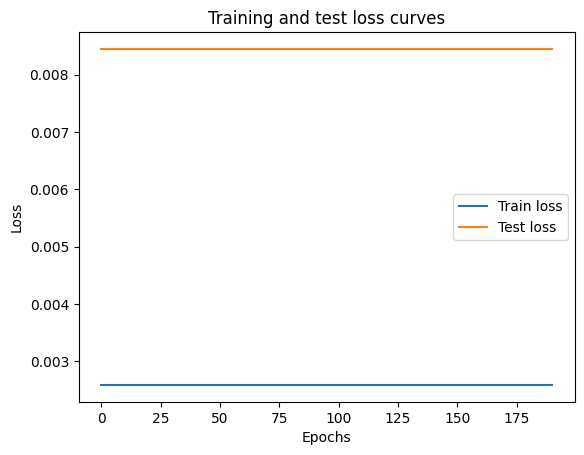

In [74]:
plt.plot(epoch_count, loss_values, label = 'Train loss')
plt.plot(epoch_count, test_loss_values, label = 'Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

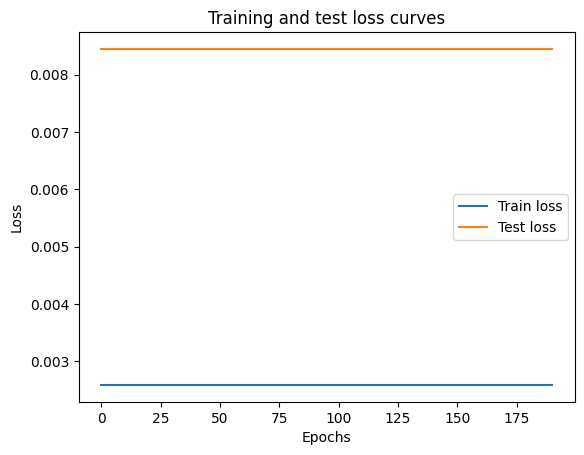

In [75]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [76]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [78]:
y_preds_new, y_test

(tensor([[0.8554],
         [0.8693],
         [0.8832],
         [0.8971],
         [0.9110],
         [0.9249],
         [0.9388],
         [0.9527],
         [0.9666],
         [0.9805]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [79]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

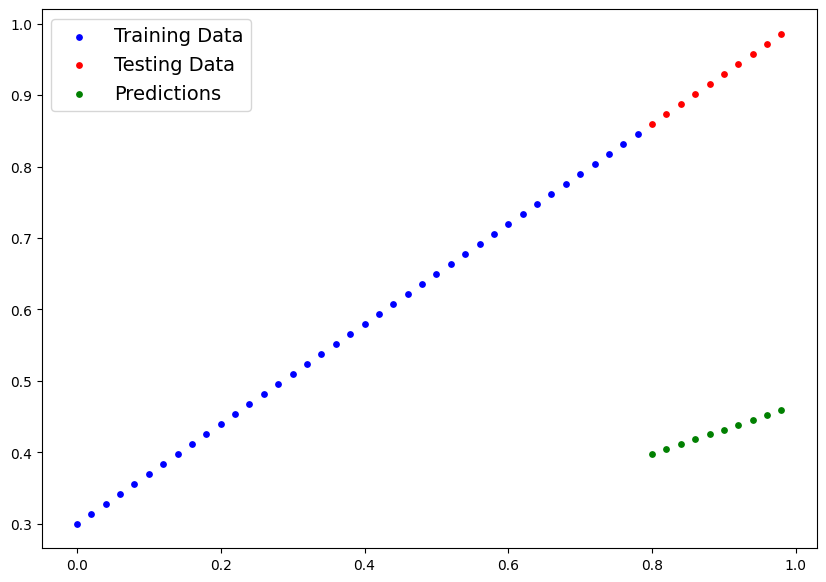

In [80]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

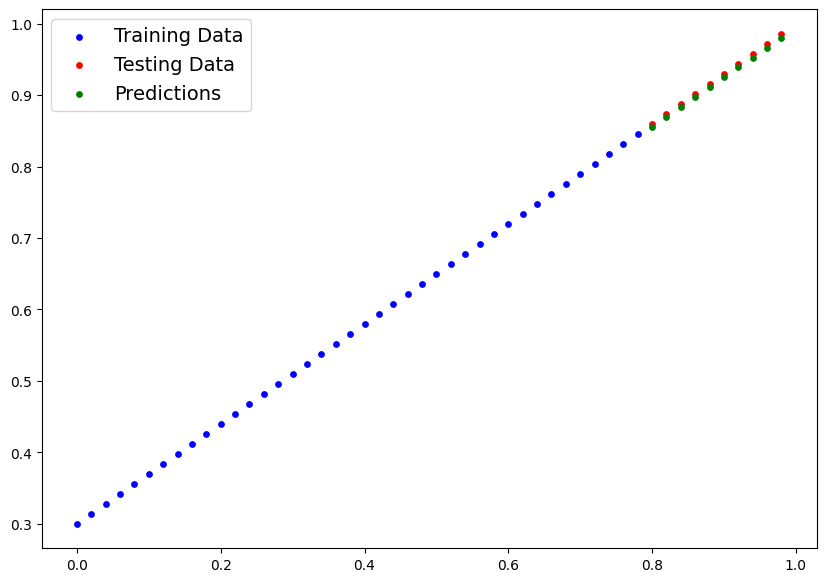

In [81]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds_new)